In [38]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def ad_hoc_data(training_size, test_size, n, gap, PLOT_DATA):
    class_labels = [r'A', r'B']
    if n == 2:
        N = 100
    elif n == 3:
        N = 20   # courseness of data seperation

    label_train = np.zeros(2*(training_size+test_size))
    sample_train = []
    sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
    sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]

    sample_Total = [[[0 for x in range(N)] for y in range(N)] for z in range(N)]

    interactions = np.transpose(np.array([[1, 0], [0, 1], [1, 1]]))

    steps = 2*np.pi/N

    sx = np.array([[0, 1], [1, 0]])
    X = np.asmatrix(sx)
    sy = np.array([[0, -1j], [1j, 0]])
    Y = np.asmatrix(sy)
    sz = np.array([[1, 0], [0, -1]])
    Z = np.asmatrix(sz)
    J = np.array([[1, 0], [0, 1]])
    J = np.asmatrix(J)
    H = np.array([[1, 1], [1, -1]])/np.sqrt(2)
    H2 = np.kron(H, H)
    H3 = np.kron(H, H2)
    H = np.asmatrix(H)
    H2 = np.asmatrix(H2)
    H3 = np.asmatrix(H3)

    f = np.arange(2**n)

    my_array = [[0 for x in range(n)] for y in range(2**n)]

    for arindex in range(len(my_array)):
        temp_f = bin(f[arindex])[2:].zfill(n)
        for findex in range(n):
            my_array[arindex][findex] = int(temp_f[findex])

    my_array = np.asarray(my_array)
    my_array = np.transpose(my_array)

    # Define decision functions
    maj = (-1)**(2*my_array.sum(axis=0) > n)
    parity = (-1)**(my_array.sum(axis=0))
    dict1 = (-1)**(my_array[0])
    if n == 2:
        D = np.diag(parity)
    elif n == 3:
        D = np.diag(maj)

    Basis = np.random.random((2**n, 2**n)) + 1j*np.random.random((2**n, 2**n))
    Basis = np.asmatrix(Basis).getH()*np.asmatrix(Basis)

    [S, U] = np.linalg.eig(Basis)

    idx = S.argsort()[::-1]
    S = S[idx]
    U = U[:, idx]

    M = (np.asmatrix(U)).getH()*np.asmatrix(D)*np.asmatrix(U)

    psi_plus = np.transpose(np.ones(2))/np.sqrt(2)
    psi_0 = 1
    for k in range(n):
        psi_0 = np.kron(np.asmatrix(psi_0), np.asmatrix(psi_plus))

    sample_total_A = []
    sample_total_B = []
    sample_total_void = []
    if n == 2:
        for n1 in range(N):
            for n2 in range(N):
                x1 = steps*n1
                x2 = steps*n2
                phi = x1*np.kron(Z, J) + x2*np.kron(J, Z) + (np.pi-x1)*(np.pi-x2)*np.kron(Z, Z)
                Uu = scipy.linalg.expm(1j*phi)
                psi = np.asmatrix(Uu)*H2*np.asmatrix(Uu)*np.transpose(psi_0)
                temp = np.asscalar(np.real(psi.getH()*M*psi))
                if temp > gap:
                    sample_Total[n1][n2] = +1
                elif temp < -gap:
                    sample_Total[n1][n2] = -1
                else:
                    sample_Total[n1][n2] = 0

        # Now sample randomly from sample_Total a number of times training_size+testing_size
        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            if sample_Total[draw1][draw2] == +1:
                sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
                tr += 1

        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            if sample_Total[draw1][draw2] == -1:
                sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
                tr += 1

        sample_train = [sampleA, sampleB]

        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            img = plt.imshow(np.asmatrix(sample_Total).T, interpolation='nearest',
                             origin='lower', cmap='copper', extent=[0, 2*np.pi, 0, 2*np.pi])
            plt.show()
            fig2 = plt.figure()
            for k in range(0, 2):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Ad-hoc Data")
            plt.show()

    elif n == 3:
        for n1 in range(N):
            for n2 in range(N):
                for n3 in range(N):
                    x1 = steps*n1
                    x2 = steps*n2
                    x3 = steps*n3
                    phi = x1*np.kron(np.kron(Z, J), J) + x2*np.kron(np.kron(J, Z), J) + x3*np.kron(np.kron(J, J), Z) + \
                        (np.pi-x1)*(np.pi-x2)*np.kron(np.kron(Z, Z), J)+(np.pi-x2)*(np.pi-x3)*np.kron(np.kron(J, Z), Z) + \
                        (np.pi-x1)*(np.pi-x3)*np.kron(np.kron(Z, J), Z)
                    Uu = scipy.linalg.expm(1j*phi)
                    psi = np.asmatrix(Uu)*H3*np.asmatrix(Uu)*np.transpose(psi_0)
                    temp = np.asscalar(np.real(psi.getH()*M*psi))
                    if temp > gap:
                        sample_Total[n1][n2][n3] = +1
                        sample_total_A.append([n1, n2, n3])
                    elif temp < -gap:
                        sample_Total[n1][n2][n3] = -1
                        sample_total_B.append([n1, n2, n3])
                    else:
                        sample_Total[n1][n2][n3] = 0
                        sample_total_void.append([n1, n2, n3])

        # Now sample randomly from sample_Total a number of times training_size+testing_size
        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            draw3 = np.random.choice(N)
            if sample_Total[draw1][draw2][draw3] == +1:
                sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N, 2*np.pi*draw3/N]
                tr += 1

        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            draw3 = np.random.choice(N)
            if sample_Total[draw1][draw2][draw3] == -1:
                sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N, 2*np.pi*draw3/N]
                tr += 1

        sample_train = [sampleA, sampleB]

        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:

            sample_total_A = np.asarray(sample_total_A)
            sample_total_B = np.asarray(sample_total_B)
            x1 = sample_total_A[:, 0]
            y1 = sample_total_A[:, 1]
            z1 = sample_total_A[:, 2]

            x2 = sample_total_B[:, 0]
            y2 = sample_total_B[:, 1]
            z2 = sample_total_B[:, 2]

            fig1 = plt.figure()
            ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
            ax1.scatter(x1, y1, z1, c='#8A360F')
            plt.show()
        #
            fig2 = plt.figure()
            ax2 = fig2.add_subplot(1, 1, 1, projection='3d')
            ax2.scatter(x2, y2, z2, c='#683FC8')
            plt.show()

            sample_training_A = training_input['A']
            sample_training_B = training_input['B']

            x1 = sample_training_A[:, 0]
            y1 = sample_training_A[:, 1]
            z1 = sample_training_A[:, 2]

            x2 = sample_training_B[:, 0]
            y2 = sample_training_B[:, 1]
            z2 = sample_training_B[:, 2]

            fig1 = plt.figure()
            ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
            ax1.scatter(x1, y1, z1, c='#8A360F')
            ax1.scatter(x2, y2, z2, c='#683FC8')
            plt.show()

    return sample_Total, training_input, test_input, class_labels


def sample_ad_hoc_data(sample_Total, test_size, n):
    tr = 0

    class_labels = [r'A', r'B']  # copied from ad_hoc_data()
    if n == 2:
        N = 100
    elif n == 3:
        N = 20

    label_train = np.zeros(2*test_size)
    sampleA = [[0 for x in range(n)] for y in range(test_size)]
    sampleB = [[0 for x in range(n)] for y in range(test_size)]
    while tr < (test_size):
        draw1 = np.random.choice(N)
        draw2 = np.random.choice(N)
        if sample_Total[draw1][draw2] == +1:
            sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
            tr += 1

    tr = 0
    while tr < (test_size):
        draw1 = np.random.choice(N)
        draw2 = np.random.choice(N)
        if sample_Total[draw1][draw2] == -1:
            sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
            tr += 1
    sample_train = [sampleA, sampleB]
    for lindex in range(test_size):
        label_train[lindex] = 0
    for lindex in range(test_size):
        label_train[test_size+lindex] = 1
    label_train = label_train.astype(int)
    sample_train = np.reshape(sample_train, (2 * test_size, n))
    test_input = {key: (sample_train[label_train == k, :])[:] for k, key in enumerate(class_labels)}
    return test_input


def Breast_cancer(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=0.3, random_state=12)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


def Digits(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C', r'D', r'E', r'F', r'G', r'H', r'I', r'J']
    data = datasets.load_digits()
    sample_train, sample_test, label_train, label_test = train_test_split(
        data.data, data.target, test_size=0.3, random_state=22)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 9):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Digits dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


def Iris(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C']
    data, target = datasets.load_iris(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=1, random_state=42)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("Iris dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


def Wine(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C']

    data, target = datasets.load_wine(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=test_size, random_state=7)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Wine dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


def Gaussian(training_size, test_size, n, PLOT_DATA):
    sigma = 1
    if n == 2:
        class_labels = [r'A', r'B']
        label_train = np.zeros(2*(training_size+test_size))
        sample_train = []
        sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]
        randomized_vector1 = np.random.randint(2, size=n)
        randomized_vector2 = (randomized_vector1+1) % 2
        for tr in range(training_size+test_size):
            for feat in range(n):
                if randomized_vector1[feat] == 0:
                    sampleA[tr][feat] = np.random.normal(-1/2, sigma, None)
                elif randomized_vector1[feat] == 1:
                    sampleA[tr][feat] = np.random.normal(1/2, sigma, None)
                else:
                    print('Nope')

                if randomized_vector2[feat] == 0:
                    sampleB[tr][feat] = np.random.normal(-1/2, sigma, None)
                elif randomized_vector2[feat] == 1:
                    sampleB[tr][feat] = np.random.normal(1/2, sigma, None)
                else:
                    print('Nope')

        sample_train = [sampleA, sampleB]
        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            fig1 = plt.figure()
            for k in range(0, 2):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Gaussians")
            plt.show()

        return sample_train, training_input, test_input, class_labels
    elif n == 3:
        class_labels = [r'A', r'B', r'C']
        label_train = np.zeros(3*(training_size+test_size))
        sample_train = []
        sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleC = [[0 for x in range(n)] for y in range(training_size+test_size)]
        randomized_vector1 = np.random.randint(3, size=n)
        randomized_vector2 = (randomized_vector1+1) % 3
        randomized_vector3 = (randomized_vector2+1) % 3
        for tr in range(training_size+test_size):
            for feat in range(n):
                if randomized_vector1[feat] == 0:
                    sampleA[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector1[feat] == 1:
                    sampleA[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector1[feat] == 2:
                    sampleA[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

                if randomized_vector2[feat] == 0:
                    sampleB[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector2[feat] == 1:
                    sampleB[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector2[feat] == 2:
                    sampleB[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

                if randomized_vector3[feat] == 0:
                    sampleC[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector3[feat] == 1:
                    sampleC[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector3[feat] == 2:
                    sampleC[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

        sample_train = [sampleA, sampleB, sampleC]
        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+training_size+test_size+lindex] = 2
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (3*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            fig1 = plt.figure()
            for k in range(0, 3):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Gaussians")
            plt.show()

        return sample_train, training_input, test_input, class_labels
    else:
        print("Gaussian presently only supports 2 or 3 qubits")

In [39]:


from qiskit import BasicAer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log


In [40]:
feature_dim=2 # we support feature_dim 2 or 3
#sample_Total - a series of 0,1 and -1
sample_Total=[[0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0], 
              [0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0], [0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0], [-1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], [-1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1], [-1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1], [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0], [1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1], [0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1], [-1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [-1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [-1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1], [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [-1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [-1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [-1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [-1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1], [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0], [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1], [0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1], [1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [-1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [-1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1], [-1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1], [-1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1], [0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1], [1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1], [1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1], [1, 1, 1, 1, 0, 0, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0], [1, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 1], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 1], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 1, 1], [-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1], [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, 0, 0, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1], [-1, -1, 0, 0, 0, 1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, 0, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 0, 0]]
#{'A': 0, 'B': 1}

print (sample_Total)
training_input = {'A': [[1.88495559, 0.18849556],
       [2.19911486, 3.0787608 ],
       [2.63893783, 3.14159265],
       [2.26194671, 1.69646003],
       [0.75398224, 1.38230077],
       [0.18849556, 1.38230077],
       [0.9424778 , 6.22035345],
       [4.39822972, 0.06283185],
       [1.0681415 , 0.31415927],
       [5.59203492, 2.95309709],
       [6.1575216 , 4.83805269],
       [4.1469023 , 2.89026524],
       [6.22035345, 4.90088454],
       [3.70707933, 0.87964594],
       [4.83805269, 3.01592895],
       [5.52920307, 1.13097336],
       [1.82212374, 3.14159265],
       [0.37699112, 3.95840674],
       [2.0106193 , 4.64955713],
       [1.57079633, 2.82743339]], 
                  'B': [[6.03185789, 6.09468975],
       [4.39822972, 3.70707933],
       [3.95840674, 2.136283  ],
       [3.01592895, 4.1469023 ],
       [1.44513262, 0.9424778 ],
       [2.95309709, 4.0212386 ],
       [4.77522083, 2.38761042],
       [2.95309709, 5.71769863],
       [0.62831853, 2.32477856],
       [1.38230077, 0.56548668],
       [0.12566371, 5.15221195],
       [1.38230077, 5.59203492],
       [6.22035345, 2.95309709],
       [5.46637122, 1.57079633],
       [1.00530965, 5.65486678],
       [4.52389342, 4.27256601],
       [4.33539786, 3.95840674],
       [1.13097336, 5.34070751],
       [4.46106157, 4.08407045],
       [5.65486678, 3.39292007]]}
#{'A': 0, 'B': 1}

test_input = {'A': [[0.06283185, 2.76460154],
       [4.90088454, 4.64955713],
       [2.45044227, 3.83274304],
       [3.0787608 , 3.58141563],
       [2.63893783, 1.94778745],
       [1.63362818, 2.19911486],
       [4.96371639, 0.69115038],
       [2.82743339, 3.83274304],
       [6.22035345, 3.45575192],
       [3.33008821, 4.20973416]], 
              'B': [[5.59203492, 3.14159265],
       [0.75398224, 3.20442451],
       [4.27256601, 0.43982297],
       [3.70707933, 3.26725636],
       [6.1575216 , 4.58672527],
       [2.07345115, 0.25132741],
       [2.70176968, 5.02654825],
       [5.78053048, 5.84336234],
       [4.33539786, 0.75398224],
       [2.89026524, 2.82743339]]}
#{'A': 0, 'B': 1}

class_labels = ['A', 'B']
#{'A': 0, 'B': 1}

extra_test_data = {'A': [[4.77522083, 5.2150438 ],
       [2.82743339, 0.62831853],
       [5.59203492, 4.1469023 ],
       [2.0106193 , 0.69115038],
       [0.06283185, 3.58141563],
       [2.19911486, 0.31415927],
       [0.06283185, 3.58141563],
       [5.59203492, 3.64424748],
       [6.09468975, 2.51327412],
       [5.52920307, 0.18849556]], 'B': [[4.33539786, 0.18849556],
       [0.56548668, 5.59203492],
       [3.89557489, 3.39292007],
       [3.20442451, 0.81681409],
       [0.87964594, 6.09468975],
       [2.51327412, 1.25663706],
       [4.90088454, 3.0787608 ],
       [5.27787566, 0.87964594],
       [4.1469023 , 4.33539786],
       [2.136283  , 4.90088454]]}
#{'A': 0, 'B': 1}

#extra_test_data = sample_ad_hoc_data(sample_Total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)
print(datapoints)

[[0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0], [0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0], [0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [

In [41]:
seed = 10598

feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2, entanglement='linear')
print(feature_map)
qsvm = QSVM(feature_map, training_input, test_input)



In [44]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

"""declarative approach, re-use the params above
algo_input = ClassificationInput(training_input, test_input)
result = run_algorithm(params, algo_input)
"""
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.25


kernel matrix during the training:


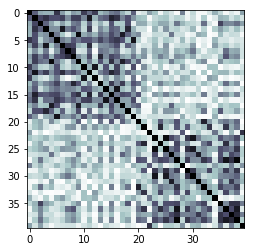

In [43]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()